<a href="https://colab.research.google.com/github/LorenzEh/LLM-Vaccine-Hesitency/blob/main/LLM_Create_Personas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries


In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes trl llama-cpp-python huggingface-hub
!pip install --upgrade fsspec==2025.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

# Getting the data ready

In [2]:
import gdown
import pandas as pd
from datasets import Dataset

In [3]:
gdown.download(id="1_n3zhxBFG0QPabe2cKeq_UY092cGDW4V", output="data_imputed_decoded.csv", quiet=False)
data = pd.read_csv("data_imputed_decoded.csv")

Downloading...
From: https://drive.google.com/uc?id=1_n3zhxBFG0QPabe2cKeq_UY092cGDW4V
To: /content/data_imputed_decoded.csv
100%|██████████| 1.00M/1.00M [00:00<00:00, 99.3MB/s]


In [4]:
data['EDU_CAT'] = data['EDU_CAT'].str.replace(r' \(Kat\. \d+(-\d+)?\)', '', regex=True) # delete the "(Kat )" in EDU_CAT

In [5]:
for col in data.columns: # get a list of all columns
    print(col)

Aussage: Akzeptabel höhere Steuern zu zahlen
Aussage: Lebensweise ändern
Aussage: Wichtigeres als Corona im Leben
Aussage: Behauptungen über Corona übertrieben
Aussage: Solange andere Verhalten nicht ändern keine Verhaltensänderung
Zufriedenheit Bundesregierung: Bilanz
Zufriedenheit Bundesregierung: Bekämpfung der Arbeitslosigkeit
Zufriedenheit Bundesregierung: Stützung der kleinen und mittleren Unternehmen
Zufriedenheit Bundesregierung: Stützung der Wirtschaft allgemein
Aussage: Beitrag zur Finanzierung durch alle Personen gleich
Aussage: Kluft zwischen Arm und Reich wird durch Krise größer
Aussage: Neue Steuern schaden Wirtschaftsstandort Österreich
Aussage: Politik muss soziale Ungleichheit bekämpfen
Aussage: Sozialstaat macht Menschen träge und faul
Aussage: Arbeitslosigkeit durch Staatsschulden bekämpfen
Aussage: Wenig Eingriff in Wirtschaft durch Politik 
Aussage: Bevorzugung von Frauen bei gleicher Qualifikation 
Aussage: Ausweitung der Befugnisse der Polizei
Aussage: Zuwanderun

In [6]:
# fixing small issue in variable names:
data.columns = data.columns.str.strip()

# Convert tabular data into sentences


1.   **Develop well-structured prompts from the tabular data:** This involves carefully crafting the input to guide the Large Language Model (LLM) effectively.
2.   **Implement a chat template for enhanced model comprehension:** Introducing a consistent chat template significantly improves the model's
understanding of the input, particularly crucial for smaller, less powerful models running on Colab's CPU. Furthermore, the prompt engineering process includes creating illustrative examples and establishing a clear structural framework within the prompts.
3.   **Adjust parameters for output optimization:** This involves fine-tuning parameters such as temperature, repeat_penalty, and top_k to achieve the desired quality and characteristics of the generated text.

Considering the model's lightweight architecture, the current results are reasonably satisfactory for most generated personas. A larger model would significantly improve outcomes, reduce reliance on extensive prompt engineering, and enable the inclusion of substantially more variables, leading to much richer and more detailed persona profiles. Also, much more distinct personas could be generated.

In [7]:
import re
import random
import torch
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

In [8]:
def create_prompts_directly(df):
    data_dict = {"prompt": [], "response": []}

    for _, row in df.iterrows():
        # Build prompt directly from row data
        prompt = f"""Person:
- Geschlecht: {row.get('GENDER', 'Unbekannt')}
- Alter: {row.get('AGE_CAT', 'Unbekannt')}
- Bildung: {row.get('EDU_CAT', 'Unbekannt')}
- Bundesland: {row.get('BULA', 'Unbekannt')}
- Impfen Ehestmöglich: {row.get('Impfen: Ehestmöglich', 'Unbekannt')}
- Verlasse mich lieber auf mein Immunsystem: {row.get('Aussage: Verlasse mich lieber auf mein Immunsystem als auf eine Impfung', 'Unbekannt')}
- Selbstschutz durch Impfung: {row.get('Aussage: Mit einer Impfung kann ich mich selbst schützen', 'Unbekannt')}
- Fremdschutz durch Impfung: {row.get('Aussage: Mit einer Impfung kann ich andere schützen', 'Unbekannt')}
- Behördeninformation: {row.get('Aussage: Behörden informieren hinreichend über Wirkungsweise der Impfstoffe', 'Unbekannt')}"""

        data_dict["prompt"].append(prompt)
        data_dict["response"].append("[PLACEHOLDER_FOR_GENERATED_PERSONA]")

    return Dataset.from_dict(data_dict)
dataset = create_prompts_directly(data).select(range(50))

In [9]:
for i in range(5):
  print(dataset["prompt"][i]) # description of person which is used in the prompt

Person:
- Geschlecht: Maennlich
- Alter: 65+ Jahre
- Bildung: Hoch
- Bundesland: Vorarlberg
- Impfen Ehestmöglich: Trifft eher nicht zu
- Verlasse mich lieber auf mein Immunsystem: Trifft gar nicht zu
- Selbstschutz durch Impfung: Teils-teils
- Fremdschutz durch Impfung: Teils-teils
- Behördeninformation: Teils-teils
Person:
- Geschlecht: Weiblich
- Alter: 50-64 Jahre
- Bildung: Niedrig
- Bundesland: Oberoesterreich
- Impfen Ehestmöglich: Trifft eher zu
- Verlasse mich lieber auf mein Immunsystem: Trifft gar nicht zu
- Selbstschutz durch Impfung: Trifft eher zu
- Fremdschutz durch Impfung: Trifft eher zu
- Behördeninformation: Trifft eher zu
Person:
- Geschlecht: Maennlich
- Alter: 40-49 Jahre
- Bildung: Mittel
- Bundesland: Niederoesterreich
- Impfen Ehestmöglich: Trifft eher zu
- Verlasse mich lieber auf mein Immunsystem: Teils-teils
- Selbstschutz durch Impfung: Trifft eher zu
- Fremdschutz durch Impfung: Trifft eher zu
- Behördeninformation: Trifft eher nicht zu
Person:
- Geschlech

In [10]:
# download the model form hugging faces
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="TheBloke/em_german_mistral_v01-GGUF", ## GGUF > not trainable
    filename="em_german_mistral_v01.Q4_K_M.gguf",
    local_dir="/content"  # save in colab enviroment
)

# initialize the model
from llama_cpp import Llama

llm = Llama(
    model_path=model_path,
    n_ctx=2048,
    n_threads=8,           # nr of cpu threads
    n_gpu_layers=0         # use cpu only
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


em_german_mistral_v01.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /content/em_german_mistral_v01.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = jphme_em_german_mistral_v01
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.atten

In [11]:
MANUAL_EXAMPLES = [
    {
        "prompt": """Person:
- Geschlecht: Maennlich
- Alter: 40-49 Jahre
- Bildung: Mittel
- Bundesland: Niederoesterreich
- Impfen Ehestmöglich: Trifft eher zu
- Verlasse mich lieber auf mein Immunsystem: Teils-teils
- Selbstschutz durch Impfung: Trifft eher zu
- Fremdschutz durch Impfung: Teils-teils
- Behördeninformation: Trifft eher nicht zu""",
        "summary": """Ich bin ein zwischen 40 und 49 Jahre alter Mann und lebe in Niederoesterreich. Ich werde mich wahrscheinlich ehestmögich impfen lassen.
Ich verlasse mich teilweise auf mein Immunsystem. Ich denke, dass man sich durch die Impfung selber schützen kann aber weiß nicht, ob man auch andere schützen kann.
Die Informationen der Behörde zur Impfung waren unzureichend."""
    },
    {
        "prompt": """Person:
- Geschlecht: Weiblich
- Alter: 65+ Jahre
- Bildung: Hoch
- Bundesland: Wien
- Impfen Ehestmöglich: Trifft voll zu
- Verlasse mich lieber auf mein Immunsystem: Trifft gar nicht zu
- Selbstschutz durch Impfung: Trifft voll zu
- Fremdschutz durch Impfung: Trifft voll zu
- Behördeninformation: Trifft voll zu""",
        "summary": """Ich bin eine in Wien lebende Frau und älter als 65 Jahre. Ich werde mich sicherlich ehestmöglich impfen lassen.
Ich verlasse mich gar nicht auf mein Immunsystem und glaube sowohl an den Fremdschutz, als auch an den Selbstschutz der Impfung.
Die Informationen der Behörden über die Impfung waren voll ausreichend."""
    }
]

# category rules (they don't work perfectly tho..)
CATEGORY_RULES = """**Antwortrichtlinien:**
1. "Trifft voll zu" → "Ich werde definitiv..." / "Sicherlich..."
2. "Trifft eher zu" → "Ich tendiere dazu..." / "Wahrscheinlich..."
3. "Teils-teils" → "Ich bin mir unsicher..." / "Vielleicht..."
4. "Trifft eher nicht zu" → "Ich werde nicht..." / "Eher nicht..."
5. "Trifft gar nicht zu" → "Ich werde auf keinen Fall..." / "Gar nicht..."'
"""

def format_prompt(prompt):
    example_text = ""
    for idx, ex in enumerate(MANUAL_EXAMPLES, 1):
        example_text += f"""
**Beispiel {idx}:**
Daten:
{ex['prompt']}
Zusammenfassung: [/INST] {ex['summary']}[INST]"""

    instruction = f"""[INST] <<SYS>>
Stell dir vor, du bist diese Person. Beschreibe dich in 2-3 Sätzen, lasse keine Informationen aus:

{CATEGORY_RULES}

{example_text}
<</SYS>>

**Aktuelle Daten:**
{prompt}
**Deine Perspektive:** [/INST]"""

    return instruction

In [12]:
def generate_persona(llm, prompt):
    full_prompt = format_prompt(prompt)

    output = llm(
        full_prompt,
        max_tokens=150,                           # lenght of the output
        temperature=0.1,                          # more creativity besser: 0.5
        top_p=0.95,                               # wider sampling: 0.95
        top_k=15,                                 # more diverse besser: 40
        repeat_penalty=1.25,                      # higher penalty = less repeating phrases or sentences: 1.20
        stop=["\n\n", "</s>", "[INST]"],          # "\n\n" = Double Newline, stop the model at a logical paragraph end // "</s>" = End-of-Sequence Token // "[INST]" =  Instruction Marker
        echo=False                                # don't return prompt
    )

    # Handle empty response
    response = output['choices'][0]['text'].strip()

    # fallback if empty
    if not response:
        return "Zusammenfassung konnte nicht generiert werden."

    return response.split("Zusammenfassung:")[-1].strip()


In [13]:
import random

# randomly sample from the dataset
sample_size = min(10, len(dataset))

valid_count = 0  # counting answers

if sample_size > 0:
    random.seed(123)
    sampled_indices = random.sample(range(len(dataset)), sample_size)

    for idx in sampled_indices:
        if valid_count >= 3:
            break

        prompt = dataset[idx]["prompt"]
        print(f"\n=== Prompt {idx+1} ===")
        print(prompt)

        for attempt in range(3):
            response = generate_persona(llm, prompt)
            if response != "Zusammenfassung konnte nicht generiert werden.":
                print("\nGenerierte Persona:")
                print(f"Persona: {response}")
                print("="*50)
                valid_count += 1
                break  # next prompt

        if valid_count >=5:
            break

    if valid_count <3:
        print(f"\nNur {valid_count} gültige Personas gefunden!")
else:
    print("Dataset ist leer!")


"""without sampling:
for i in range(10):
    prompt = dataset[i]["prompt"]
    response = generate_persona(llm, prompt)

    if response == "Zusammenfassung konnte nicht generiert werden.":
        continue  # Überspringe diesen Eintrag, wenn keine gültige Antwort

    print(f"Prompt {i+1}:")
    print(prompt)
    print("\nGenerierte Persona:")
    print(response)
    print("\n" + "="*50 + "\n")
"""


=== Prompt 4 ===
Person:
- Geschlecht: Maennlich
- Alter: 40-49 Jahre
- Bildung: Mittel
- Bundesland: Niederoesterreich
- Impfen Ehestmöglich: Trifft eher zu
- Verlasse mich lieber auf mein Immunsystem: Teils-teils
- Selbstschutz durch Impfung: Trifft eher zu
- Fremdschutz durch Impfung: Teils-teils
- Behördeninformation: Trifft eher nicht zu


llama_perf_context_print:        load time =  252796.55 ms
llama_perf_context_print: prompt eval time =  252794.61 ms /   840 tokens (  300.95 ms per token,     3.32 tokens per second)
llama_perf_context_print:        eval time =   69890.93 ms /   114 runs   (  613.08 ms per token,     1.63 tokens per second)
llama_perf_context_print:       total time =  322823.37 ms /   954 tokens
Llama.generate: 711 prefix-match hit, remaining 131 prompt tokens to eval



Generierte Persona:
Persona: Ich bin ein zwischen 40 und 49 Jahre alter Mann und lebe in Niederoesterreich. Ich werde mich wahrscheinlich ehestmögich impfen lassen.
Ich verlasse mich teilweise auf mein Immunsystem. Ich denke, dass man sich durch die Impfung selber schützen kann aber weiß nicht, ob man auch andere schützen kann.
Die Informationen der Behörde zur Impfung waren unzureichend.

=== Prompt 18 ===
Person:
- Geschlecht: Weiblich
- Alter: 40-49 Jahre
- Bildung: Mittel
- Bundesland: Oberoesterreich
- Impfen Ehestmöglich: Trifft gar nicht zu
- Verlasse mich lieber auf mein Immunsystem: Trifft voll und ganz zu
- Selbstschutz durch Impfung: Trifft gar nicht zu
- Fremdschutz durch Impfung: Trifft gar nicht zu
- Behördeninformation: Trifft gar nicht zu


llama_perf_context_print:        load time =  252796.55 ms
llama_perf_context_print: prompt eval time =   39399.67 ms /   131 tokens (  300.76 ms per token,     3.32 tokens per second)
llama_perf_context_print:        eval time =   57532.53 ms /    97 runs   (  593.12 ms per token,     1.69 tokens per second)
llama_perf_context_print:       total time =   97038.16 ms /   228 tokens
Llama.generate: 720 prefix-match hit, remaining 127 prompt tokens to eval



Generierte Persona:
Persona: Ich bin eine zwischen 40 und 49 Jahre alte Frau aus Oberösterreich. Ich werde mich definitiv nicht ehestmöglich impfen lassen, denn ich verlaße voll und ganz auf mein Immunsystem und glaube gar nicht an Selbst- oder Fremdschutz durch Impfung.
Die Informationen der Behörden zur Impfung waren unzureichend.[/INST]

=== Prompt 6 ===
Person:
- Geschlecht: Weiblich
- Alter: 50-64 Jahre
- Bildung: Mittel
- Bundesland: Niederoesterreich
- Impfen Ehestmöglich: Trifft voll und ganz zu
- Verlasse mich lieber auf mein Immunsystem: Trifft gar nicht zu
- Selbstschutz durch Impfung: Trifft voll und ganz zu
- Fremdschutz durch Impfung: Trifft voll und ganz zu
- Behördeninformation: Trifft eher zu


llama_perf_context_print:        load time =  252796.55 ms
llama_perf_context_print: prompt eval time =   39146.98 ms /   127 tokens (  308.24 ms per token,     3.24 tokens per second)
llama_perf_context_print:        eval time =   92775.57 ms /   149 runs   (  622.65 ms per token,     1.61 tokens per second)
llama_perf_context_print:       total time =  132094.18 ms /   276 tokens



Generierte Persona:
Persona: Ich bin eine zwischen 50 und 64 Jahre alte Frau aus Niederoesterreich. Ich werde mich sicherlich ehestmöglich impfen lassen, weil ich glaube, dass sowohl der Selbstschutz als auch der Fremdschutz durch die Impfung sehr hoch ist und das Risiko einer Erkrankung durch COVID-19 für mich zu groß wäre.
Ich verlasse gar nicht auf mein Immunsystem und denke, dass es ratsam ist sich selbst schützen zu lassen. Die Informationen der Behörde waren zwar ausreichend, aber ich hätte gerne mehr


'without sampling:\nfor i in range(10):\n    prompt = dataset[i]["prompt"]\n    response = generate_persona(llm, prompt)\n\n    if response == "Zusammenfassung konnte nicht generiert werden.":\n        continue  # Überspringe diesen Eintrag, wenn keine gültige Antwort\n\n    print(f"Prompt {i+1}:")\n    print(prompt)\n    print("\nGenerierte Persona:")\n    print(response)\n    print("\n" + "="*50 + "\n")\n'

Further optimization is certainly achievable. For a lightweight model running solely on CPU, the current results are somewhat reasonable (parameters such as top_k, temperature, etc., are very important and drastically change how well the sentences are created from the prompt). A more powerful model would deliver much faster and better outcomes, enabling the generation of a greater number of personas with significantly more variables included in the prompt. This enhancement could be realized through local GPU utilization, investment in API quotas, or the utilization of outsourced GPU resources.

# Notes for improvement:

**General Questions:**
* Fine-tuning vs. Prompt-Engineering: When working with large models, such as GPT-4o, fine tuning needs huge amounts of data (syntethic data?). Literature below focuses on clever prompt-engineering (prompts can be ~260 pages long)

##[**Stanford technique**](https://arxiv.org/pdf/2411.10109)

* **Web Platform Usage for Organization:**
    * **Qualitative Interviews:** These interviews served as the basis for their prompts and were conducted using an AI tool. The AI tool's output was then tested and evaluated by human experts.
    * **Surveys:** Various surveys were utilized to assess the performance of the Language Model (LLM), including:
        * General Social Survey
        * Big Five Personality Traits
        * Behavioral Economic Games

The researchers prompted GPT-4o with the interview questions and then compared its responses to those of real human participants, evaluating the results.


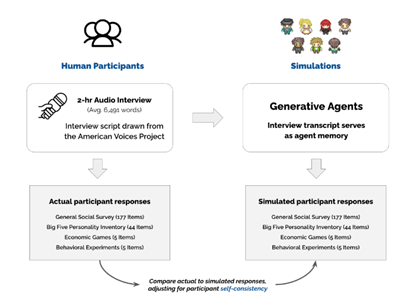

  * In our case: we could check for the 7-C Model and much more (...).

* **Memory Stream Utilization:**
    * **Reflection Module:** This module prompts GPT-4o to read the interview transcript and generate "reflections." These reflections are high-level insights written by virtual experts.
        * **Purpose:** This generated data is stored in the memory stream, which functions as a database containing structured and searchable memory for each individual. They implement this strategy to craft even more specific prompts by combining these reflections with the interview transcript. Given the substantial input (transcript), providing the LLM with this additional information is advantageous as it helps prevent the model from "getting lost" and maintains simulation consistency.

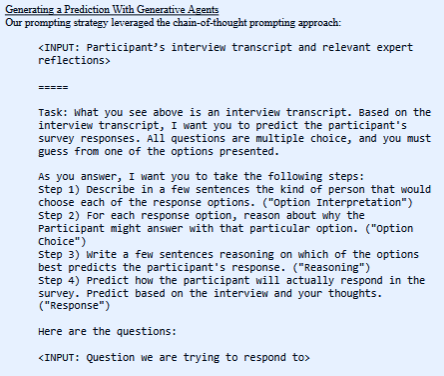


  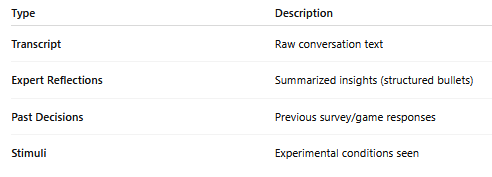



For memory streams, various technologies like **vector databases** or **JSON** can be employed as backends. The necessity of such a backend hinges on the volume of data to be stored.

If only small amounts of data are required, you can store the information directly within a **Python script** (for an example, see [Econ Agent](https://arxiv.org/pdf/2310.10436)). However, for larger datasets, especially when extensive prompting and data utilization are involved, **memory streams** become highly beneficial. In these cases, organizing data in a database offers a much more elegant solution compared to alternatives like JSONs or CSVs.

####Timeline of the Stanford Study:

**Collect Ground Truth from Real People:**

* Interview each person (~2 hours, 6,500 words)
* Ask them to take surveys:

  GSS (177 questions)

  BFI-44 (personality)

  Play economic games

  Go through experimental tasks

* These are real responses, forming the “ground truth” to compare against.

**Build Synthetic Agents**

* Use their interview transcript

* Generate expert reflections (psychologist, political scientist, etc.)

* Save this in a memory stream

* These are synthetic models of the person, but they’ve never seen the survey answers.

**Simulate Survey Responses with LLM**

* Now they prompt the model:

    “Based on the interview + expert reflections, how would this person likely respond to Question X on the GSS?”

* This process is blind — the model doesn’t know the real answer.

**Now they compare:**

* Synthetic response (LLM-predicted)
* Real response (human answer)

**They evaluate:**

* Match rate (exact match)

* Statistical correlation across scales

* Behavioral fidelity (do groups behave as expected?)


## [VACSim Workflow]()

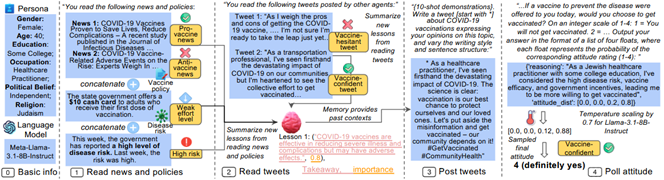

1. **Agent Creation**

* Each of the 100 agents is initialized with a synthetic demographic profile (e.g., age, education, occupation, religion, political belief), sampled from real-world vaccine hesitancy survey data (Nguyen et al., 2022).

* Agents are “instantiated” using a persona-prompt to an LLM (e.g., Meta-Llama-3.1-8B-Instruct).

2. **Memory & Knowledge Update** (no backend or database mentioned in the text)

* At each simulation step (equivalent to one week), agents:

* Read simulated news

* Receive vaccine policies

* Read and write tweets (via their social network)

* Update memory with key “lessons” derived from this content

3. **Memory Module**

* Each lesson is assigned an importance score (saliency) and stored.

* Only the top 5 most salient lessons are fed into the agent's context at each step, simulating bounded memory.

4. **Decision-Making: Vaccine Attitude**
* Agents express their vaccine hesitancy using a probabilistic distribution over four Likert-like options:

  1: Definitely not

  2: Probably not

  3: Probably yes

  4: Definitely yes

Mainly about policy impact and the social network.

# Option 2: Utilizing Google Gemini API (API-Key necessary)

Results are much better but the generation only possible with enough credits

In [ ]:
!pip -q install google-generativeai

In [ ]:
import google.generativeai as genai
import time

In [ ]:
from google.colab import userdata
genai.configure(api_key=userdata.get("gemini_key"))

In [ ]:
for m in genai.list_models():
    if 'gemini' in m.name:
        print(m.name)

models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-

In [ ]:
# initialize model
model = genai.GenerativeModel("gemini-1.5-pro")

# this function uses the prompt which was generated with create_prompts_directly

def generate_persona_gemini(prompt):
    system_instruction = """Erstelle eine Personenbeschreibung in 2-3 Sätzen auf Deutsch:
1. Demographie (Alter, Geschlecht, Bildung, Bundesland)
2. Impfverhalten und Begründungen

Beispielantwort:
Ich bin eine 65-jährige Frau mit hoher Bildung aus Vorarlberg. Ich stehe Impfungen eher skeptisch gegenüber und werde mich wahrscheinlich nicht ehestmöglich impfen lassen.
Ich vertraue zwar nicht vollständig auf mein Immunsystem, bin mir aber unsicher, ob Impfungen wirklich Selbst- oder Fremdschutz bieten. Die Informationen der Behörden empfinde ich als teilweise unzureichend."""

    full_prompt = f"{system_instruction}\n\nAktuelle Daten:\n{prompt}" # use the prompt which was generated with create_prompts_directly

    try:
        response = model.generate_content(
            full_prompt,
            generation_config={
                "temperature": 0.3,  # Less randomness
                "max_output_tokens": 200,
            }
        )
        return response.text
    except Exception as e:
        print(f"Error: {e}")
        return None

# process first 5 entries with rate limiting
for i in range(5):
    prompt = dataset[i]["prompt"]
    print(f"Processing prompt {i+1}...")

    persona = generate_persona_gemini(prompt)
    if persona:
        print("\nGenerated Persona:")
        print(persona)
        print("\n" + "="*50 + "\n")

    time.sleep(1)  # rate limiting (1 request/sec)

print("Done!")

Processing prompt 1...

Generated Persona:
Ich bin ein über 65-jähriger Mann mit hoher Bildung aus Vorarlberg.  Obwohl ich mich nicht ausschließlich auf mein Immunsystem verlasse, bin ich beim Thema Impfen noch unentschlossen und werde mich daher eher nicht ehestmöglich impfen lassen.  Der Nutzen von Impfungen hinsichtlich Selbst- und Fremdschutz ist für mich nicht eindeutig geklärt, und die Informationen der Behörden empfinde ich als teilweise unzureichend.



Processing prompt 2...

Generated Persona:
Ich bin eine Frau zwischen 50 und 64 Jahren mit niedriger Bildung aus Oberösterreich. Ich lasse mich ehestmöglich impfen, da ich nicht auf mein Immunsystem vertrauen möchte und an den Selbst- und Fremdschutz durch Impfungen glaube.  Die Informationen der Behörden halte ich für ausreichend.



Processing prompt 3...

Generated Persona:
Ich bin ein Mann zwischen 40 und 49 Jahren mit mittlerer Bildung aus Niederösterreich. Ich lasse mich eher ehestmöglich impfen, da ich vom Selbst- und Fre

Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
Processing prompt 5...
Error: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
Done!


# Option 2: Utilizing Hugging Face Inference API (API-Key necessary)

Unfortunately, the last output was overwritten due to missing credits for the text generation. The results are comparable to those from the Gemini API.

In [ ]:
from huggingface_hub import InferenceClient

In [ ]:
from huggingface_hub import login
login() # check if the token works (needs to be a "read" token)

In [ ]:
llm_client = InferenceClient(
    model="HuggingFaceH4/zephyr-7b-beta",  # German-focused model
    token=True,  # Uses the token from login()
    timeout=300
)


In [ ]:
def generate_persona(prompt: str) -> str:
    system_msg = """<|system|>
Erstelle eine Personenbeschreibung in 2-3 Sätzen:
1. Demographie (Alter, Geschlecht, Bildung, Bundesland)
2. Impfverhalten und Begründungen
</s>
"""
    user_msg = f"<|user|>\n{prompt}\n</s>\n<|assistant|>"

    try:
        response = llm_client.text_generation(
            prompt=system_msg + user_msg,
            max_new_tokens=150,
            temperature=0.3,
            repetition_penalty=1.15,
            stop_sequences=["</s>", "\n\n"]
        )
        return response.split("<|assistant|>")[-1].strip()
    except Exception as e:
        print(f"Generation failed: {e}")
        return ""

# Step 4: Test with your data
for i in range(5):
    prompt = dataset[i]["prompt"]
    print(f"Prompt {i+1}:")
    print(generate_persona(prompt))
    print("="*50)

Prompt 1:
Generation failed: 402 Client Error: Payment Required for url: https://router.huggingface.co/hf-inference/models/HuggingFaceH4/zephyr-7b-beta (Request ID: Root=1-6811d5a6-7cd05406270b3469634fea2c;278ea669-4801-4907-9da6-48b059c977e2)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

Prompt 2:
Generation failed: 402 Client Error: Payment Required for url: https://router.huggingface.co/hf-inference/models/HuggingFaceH4/zephyr-7b-beta (Request ID: Root=1-6811d5a6-7b2ac1746d88500a19480148;a6b6d904-9034-41e4-ad69-40173d273b9f)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

Prompt 3:
Generation failed: 402 Client Error: Payment Required for url: https://router.huggingface.co/hf-inference/models/HuggingFaceH4/zephyr-7b-beta (Request ID: Root=1-6811d5a6-24fd498824e2fed34a2ed2aa;31c5bc36-27e2-4ff3-864a-c5132f5cf3b8)


# Possible options for fine-tuning

In [ ]:
""" preparing the data for our prompt structure from before (there would probably be much more variables in a real scenario):

- Geschlecht: Maennlich
- Alter: 65+ Jahre
- Bildung: Hoch
- Bundesland: Vorarlberg
- Impfen Ehestmöglich: Trifft eher nicht zu
- Verlasse mich lieber auf mein Immunsystem: Trifft gar nicht zu
- Selbstschutz durch Impfung: Teils-teils
- Fremdschutz durch Impfung: Teils-teils
- Behördeninformation: Teils-teils

"""

def format_structured_data(examples):
    return {
        "text": f"[INST] <<SYS>>\nErstelle eine Personenbeschreibung basierend auf:\n{examples['prompt']}\n<</SYS>>\n[/INST]\n{examples['response']}"
    }

# load model with QLoRA
model_id = "LeoLM/leo-mistral-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True, # this activates QLoRA
    device_map="auto"
)

# prepare dataset
train_dataset = dataset.map(format_structured_data, remove_columns=["prompt", "response"])
tokenized_dataset = train_dataset.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=512),
    batched=True
)

# since LoRA and QLoRA
from peft import LoraConfig, prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj"], # query, key and value vectors, probably needed for persona generation
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# training
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        learning_rate=2e-4,
        fp16=True,
        output_dir="./results",
    ),
    train_dataset=tokenized_dataset,
    data_collator=lambda data: {"input_ids": torch.stack([f["input_ids"] for f in data])}
)
trainer.train()
